# Imports

In [1]:
import polars as pl
import pandas as pd
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from datetime import datetime
import sys, os, requests
import numpy as np
import ulmo

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from torch_cluster import knn_graph

In [2]:
sys.path.append('../scrapers')

import snotel_scraper
X = snotel_scraper.values_df

KeyboardInterrupt: 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.4.1+cu124
True
NVIDIA GeForce RTX 3080


In [38]:
df1 = pd.DataFrame(X)
df1.index = pd.to_datetime(df1.index)
df1 = df1.resample('MS').mean()
df1 = df1[df1.index.year >= 1985]
df1 = df1.reset_index()
df1 = df1.rename(columns={'datetime': 'DATE'})
df1.rename(columns=lambda x: x.replace('SNOTEL:', ''))
df1.to_csv("snotel_swe.csv")

# Data Import

In the future might change this to pull from a cloud MySQL database, look into how to set up databases and files.

In [14]:
sys.path.append('..')

from database.db_operations import Database

data_retrieval = Database(
    project_id=os.getenv("PROJECT_ID"),
    region=os.getenv("REGION"),
    instance_name=os.getenv("INSTANCE_NAME"),
    db_user=os.getenv("DB_USER"),
    db_pass=os.getenv("DB_PASS"),
    db_name=os.getenv("DB_NAME")
)

snotel = data_retrieval.pull_table("ao_pdo_enso.snotel")
snotel_static = data_retrieval.pull_table("ao_pdo_enso.snotel_static")
climate_indices = data_retrieval.pull_table("ao_pdo_enso.climate_indices")


snotel_static = pd.DataFrame(snotel_static)
climate_indices = pd.DataFrame(climate_indices)
snotel = pd.DataFrame(snotel).replace(-9999, np.nan)

Created engine: Engine(mysql+pymysql://)


# Data Visualization

In [74]:
sites_ca_location['elevation_m']=sites_ca_location['elevation_m'].astype(float)

In [75]:
import folium
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# Initialize a map
m = folium.Map(location=[sites_ca_location['latitude'].mean(), sites_ca_location['longitude'].mean()], zoom_start=8, tiles="Cartodb dark_matter")

# Define color map based on elevation
cmap = plt.get_cmap('OrRd')  # Choose your colormap
norm = Normalize(vmin=sites_ca_location['elevation_m'].min(), vmax=sites_ca_location['elevation_m'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)

# Function to get color from elevation
def color_scale(elevation):
    # Normalize elevation and get color from colormap
    color = sm.to_rgba(elevation)[:3]  # Get RGB values
    # Convert to hex format
    return f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'

# Add points to the map with color coding based on elevation
for _, row in sites_ca_location.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        color=color_scale(row['elevation_m']),
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(f"Name: {row['name']}<br>Elevation: {row['elevation_m']} meters")
    ).add_to(m)


In [76]:
from IPython.display import display

display(m)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4a041eb9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4a041ebeb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4a041eb6a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f4a04188430>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4a041886d0>,
 'means': []}

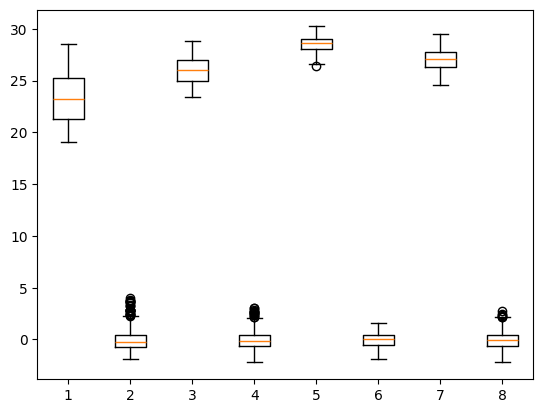

In [77]:
plt.boxplot(ensodf.iloc[:, 2:-1])

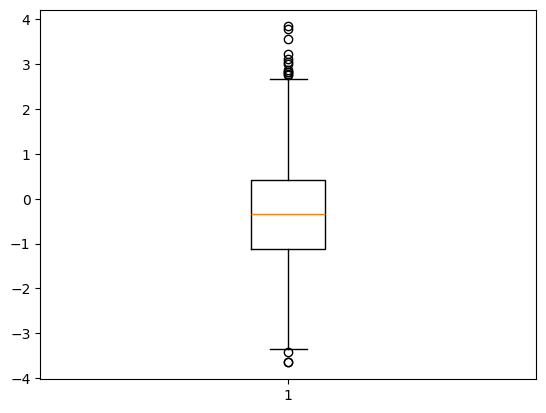

In [78]:
plt.boxplot(pdodf['Value']);

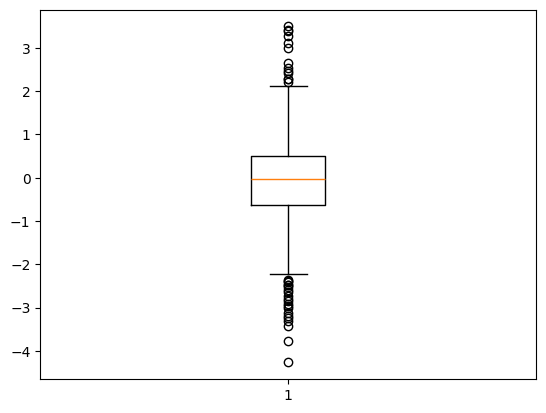

In [79]:
plt.boxplot(aodf['Value'].dropna());

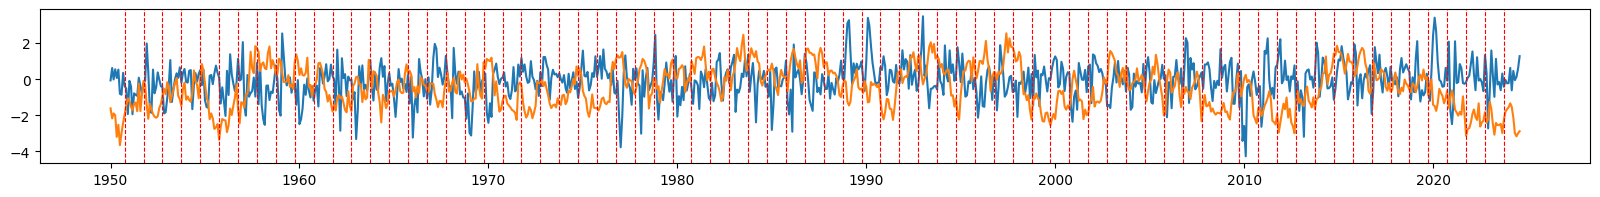

In [80]:
october_firsts = aodf[aodf['DATE'].dt.strftime('%m-%d') == '10-01']['DATE']

pdodf_sub = pdodf[pdodf['DATE'].dt.strftime('%Y') >= '1950']

fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.plot(aodf['DATE'], aodf['Value'])
ax.plot(pdodf_sub['DATE'], pdodf_sub['Value'])


for date in october_firsts:
    ax.axvline(x=date, color='red', linestyle='--', linewidth=0.8)

plt.show()

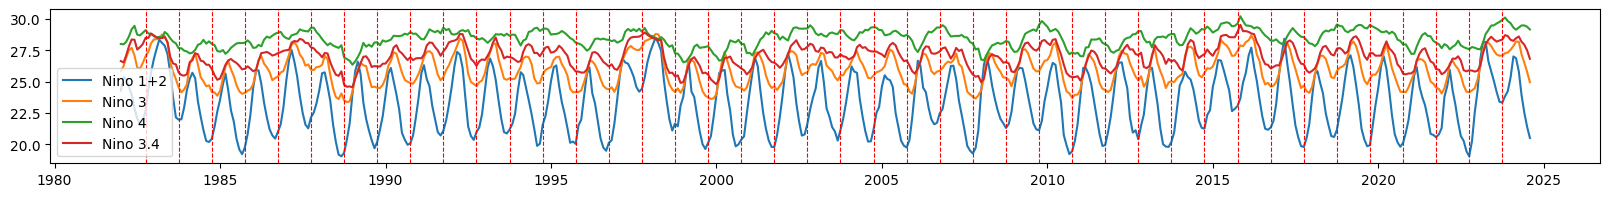

In [81]:
october_firsts = ensodf[ensodf['DATE'].dt.strftime('%m-%d') == '10-01']['DATE']

fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.plot(ensodf['DATE'], ensodf['NINO1+2'], label = "Nino 1+2")
ax.plot(ensodf['DATE'], ensodf['NINO3'], label = "Nino 3")
ax.plot(ensodf['DATE'], ensodf['NINO4'], label = "Nino 4")
ax.plot(ensodf['DATE'], ensodf['NINO3.4'], label = "Nino 3.4")

ax.legend()

for date in october_firsts:
    ax.axvline(x=date, color='red', linestyle='--', linewidth=0.8)

plt.show()

# EDA and Nulls

Todo:
<ul>
<li>Try to find daily snow water equivalent API pulls from snotel scraper</li>
<li>Feature engineering to account for lat, lon, and elevation</li>
<li>Create pipeline</li>
<li>Automate Scrapers to pull monthly</li>
<li>automate model to retrain yearly</li>
<li>Graph NN and LSTM implimentation</li>
<li>Testing</li>
</ul>

In [6]:
print(snotel.head())
print(climate_indices.head())
print(snotel_static.head())

#These are the dataframes that need analysis

                 DATE  301_CA_SNTL_PREC  356_CA_SNTL_PREC  1051_CA_SNTL_PREC  \
0 1978-10-01 00:00:00               NaN               NaN                NaN   
1 1978-10-01 04:00:00               NaN               NaN                NaN   
2 1978-10-01 05:00:00               NaN               NaN                NaN   
3 1978-10-01 13:00:00               NaN               NaN                NaN   
4 1978-10-01 14:00:00               NaN               NaN                NaN   

   1067_CA_SNTL_PREC  391_CA_SNTL_PREC  977_CA_SNTL_PREC  428_CA_SNTL_PREC  \
0                NaN               0.0               NaN               NaN   
1                NaN               NaN               NaN               NaN   
2                NaN               NaN               NaN               NaN   
3                NaN               NaN               NaN               NaN   
4                NaN               NaN               NaN               NaN   

   446_CA_SNTL_PREC  462_CA_SNTL_PREC  ...  724_CA

In [9]:
snotel = snotel.resample('MS', on='DATE').sum() 
snotel = snotel.reset_index()
snotel.head()
#TODO: There is definitely NaNs I didn't deal with

,DATE,301_CA_SNTL_PREC,356_CA_SNTL_PREC,1051_CA_SNTL_PREC,1067_CA_SNTL_PREC,391_CA_SNTL_PREC,977_CA_SNTL_PREC,428_CA_SNTL_PREC,446_CA_SNTL_PREC,462_CA_SNTL_PREC,...,724_CA_SNTL_PREC,771_CA_SNTL_PREC,778_CA_SNTL_PREC,784_CA_SNTL_PREC,1258_CA_SNTL_PREC,1052_CA_SNTL_PREC,809_CA_SNTL_PREC,834_CA_SNTL_PREC,846_CA_SNTL_PREC,848_CA_SNTL_PREC
0,1978-10-01,0.0,0.0,0.0,0.0,22.6,0.0,0.0,0.0,15.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,11.1
1,1978-11-01,0.0,0.0,0.0,0.0,53.6,0.0,0.0,0.0,315.0,...,0.0,95.9,0.0,0.0,0.0,0.0,0.0,0.0,175.3,244.6
2,1978-12-01,0.0,0.0,0.0,0.0,244.8,0.0,0.0,0.0,657.6,...,0.0,408.5,0.0,0.0,0.0,0.0,0.0,0.0,409.8,493.1
3,1979-01-01,0.0,0.0,0.0,0.0,351.9,0.0,0.0,0.0,1059.4,...,0.0,652.9,0.0,0.0,0.0,0.0,0.0,0.0,699.3,626.7
4,1979-02-01,0.0,0.0,0.0,0.0,725.4,0.0,0.0,0.0,1754.0,...,0.0,1178.2,0.0,0.0,0.0,0.0,0.0,0.0,1045.5,975.3


In [10]:
climate_indices['DATE']=pd.to_datetime(climate_indices['DATE'])
climate_indices.head()

,DATE,NINO12,ANOM,NINO3,ANOM1,NINO4,ANOM2,NINO34,ANOM3,pdo_value,ao_value
0,1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,0.11,-0.883
1,1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.19,0.974
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.37,1.074
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,-0.70,1.454
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,-1.21,-0.209


In [11]:
df = climate_indices.merge(snotel)
df.head()

In [13]:
coordinates=snotel_static[['elevation_m', 'latitude', 'longitude']].values

coordinates_tensor=torch.tensor(coordinates, dtype=torch.float)

In [21]:
edge_index = knn_graph(coordinates_tensor, k=5, loop=False)

In [19]:
data_retrieval.pull_table("ao_pdo_enso.snotel_static")

[('301_CA_SNTL', 1886.7120361328125, 41.2358283996582, -120.79192352294922),
 ('356_CA_SNTL', 2458.821533203125, 38.608001708984375, -119.92436981201172),
 ('1051_CA_SNTL', 2477.71923828125, 38.71942901611328, -119.89420318603516),
 ('1067_CA_SNTL', 2548.1279296875, 38.69269943237305, -120.002197265625),
 ('391_CA_SNTL', 2142.743896484375, 41.58232879638672, -120.30249786376953),
 ('977_CA_SNTL', 1575.8160400390625, 41.89318084716797, -120.75202178955078),
 ('428_CA_SNTL', 2101.291259765625, 39.32564926147461, -120.36807250976562),
 ('446_CA_SNTL', 2243.327880859375, 41.991268157958984, -120.18032836914062),
 ('462_CA_SNTL', 2639.872802734375, 38.54970169067383, -119.80467987060547),
 ('463_CA_SNTL', 2332.634521484375, 38.8489990234375, -120.07949829101562),
 ('473_CA_SNTL', 1902.5616455078125, 38.93402862548828, -120.05449676513672),
 ('1049_CA_SNTL', 2443.58154296875, 38.68244934082031, -119.95970153808594),
 ('1277_CA_SNTL', 2196.998291015625, 40.68798828125, -120.60804748535156),
 

In [2]:
import sys, os

sys.path.append('/home/wilder/myprojects/sierra-precip/src')

from preprocessing import DataProcessed
from pipelines import create_pipe1

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df1 = DataProcessed()
df1 = df1.pull()

date_arr=pd.date_range('1985-01-01', '2024-08-01', freq='MS')

Created engine: Engine(mysql+pymysql://)


In [16]:
df1=df1.iloc[:, :14].drop(columns=['index', 'FIELD1', 'SNOTEL301_CA_SNTL_SWE'])
pipeline = create_pipe1()
df = pipeline.fit_transform(df1)

In [17]:
cols = df1.columns
df2 = pd.DataFrame(df, columns=cols)
df2.index = date_arr

<Axes: >

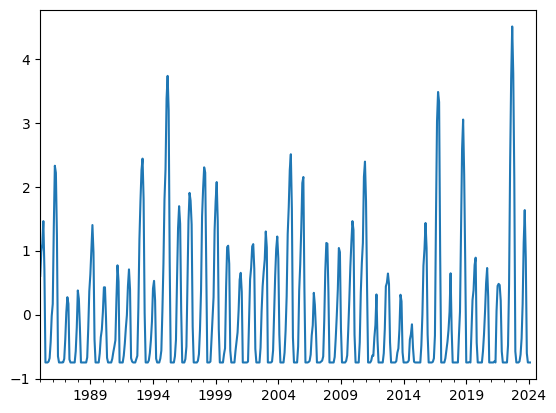

In [19]:
df2.iloc[:, -1].plot()

In [20]:
decomposed_snotel = seasonal_decompose(df2.iloc[:, -1].dropna()).trend

In [27]:
df = df2.dropna()

In [28]:
df

,NINO12,ANOM,NINO3,ANOM1,NINO4,ANOM2,NINO34,ANOM3,pdo_value,ao_value,SNOTEL356_CA_SNTL_SWE
1985-01-01,0.158283,-0.850994,-1.393555,-1.568571,-1.581579,-1.178327,-1.890993,-1.494362,1.110613,-2.773529,0.605397
1985-02-01,0.677173,-1.216851,-0.604148,-1.274327,-1.381791,-0.782964,-1.306890,-1.037990,0.785330,-1.448803,0.983797
1985-03-01,1.053368,-0.870770,0.193482,-1.062470,-1.809909,-1.421628,-0.733408,-1.001960,0.101401,0.482038,1.105938
1985-04-01,0.465293,-1.345396,0.547071,-1.038931,-1.538768,-1.573691,-0.351086,-1.254166,-0.048729,0.579986,1.461586
1985-05-01,-0.217912,-1.800246,0.012576,-1.368485,-1.124920,-1.558484,-0.244886,-1.230146,-0.340650,-0.471260,0.708379
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.050181,2.501050,0.917106,2.421386,2.043156,1.969373,1.401221,1.976469,-1.474971,-0.453804,0.883209
2023-11-01,0.270709,2.263737,1.073342,2.515544,2.314297,2.273499,1.783543,2.348773,-1.107985,-0.087226,-0.604046
2023-12-01,0.443672,1.462806,1.114457,2.492005,1.914720,2.197468,1.698582,2.456861,-0.999557,-0.266636,-0.747742
2024-01-01,0.919321,0.889300,1.295363,2.268379,1.672120,2.288705,1.379981,2.204656,-0.907811,-0.255968,-0.747742


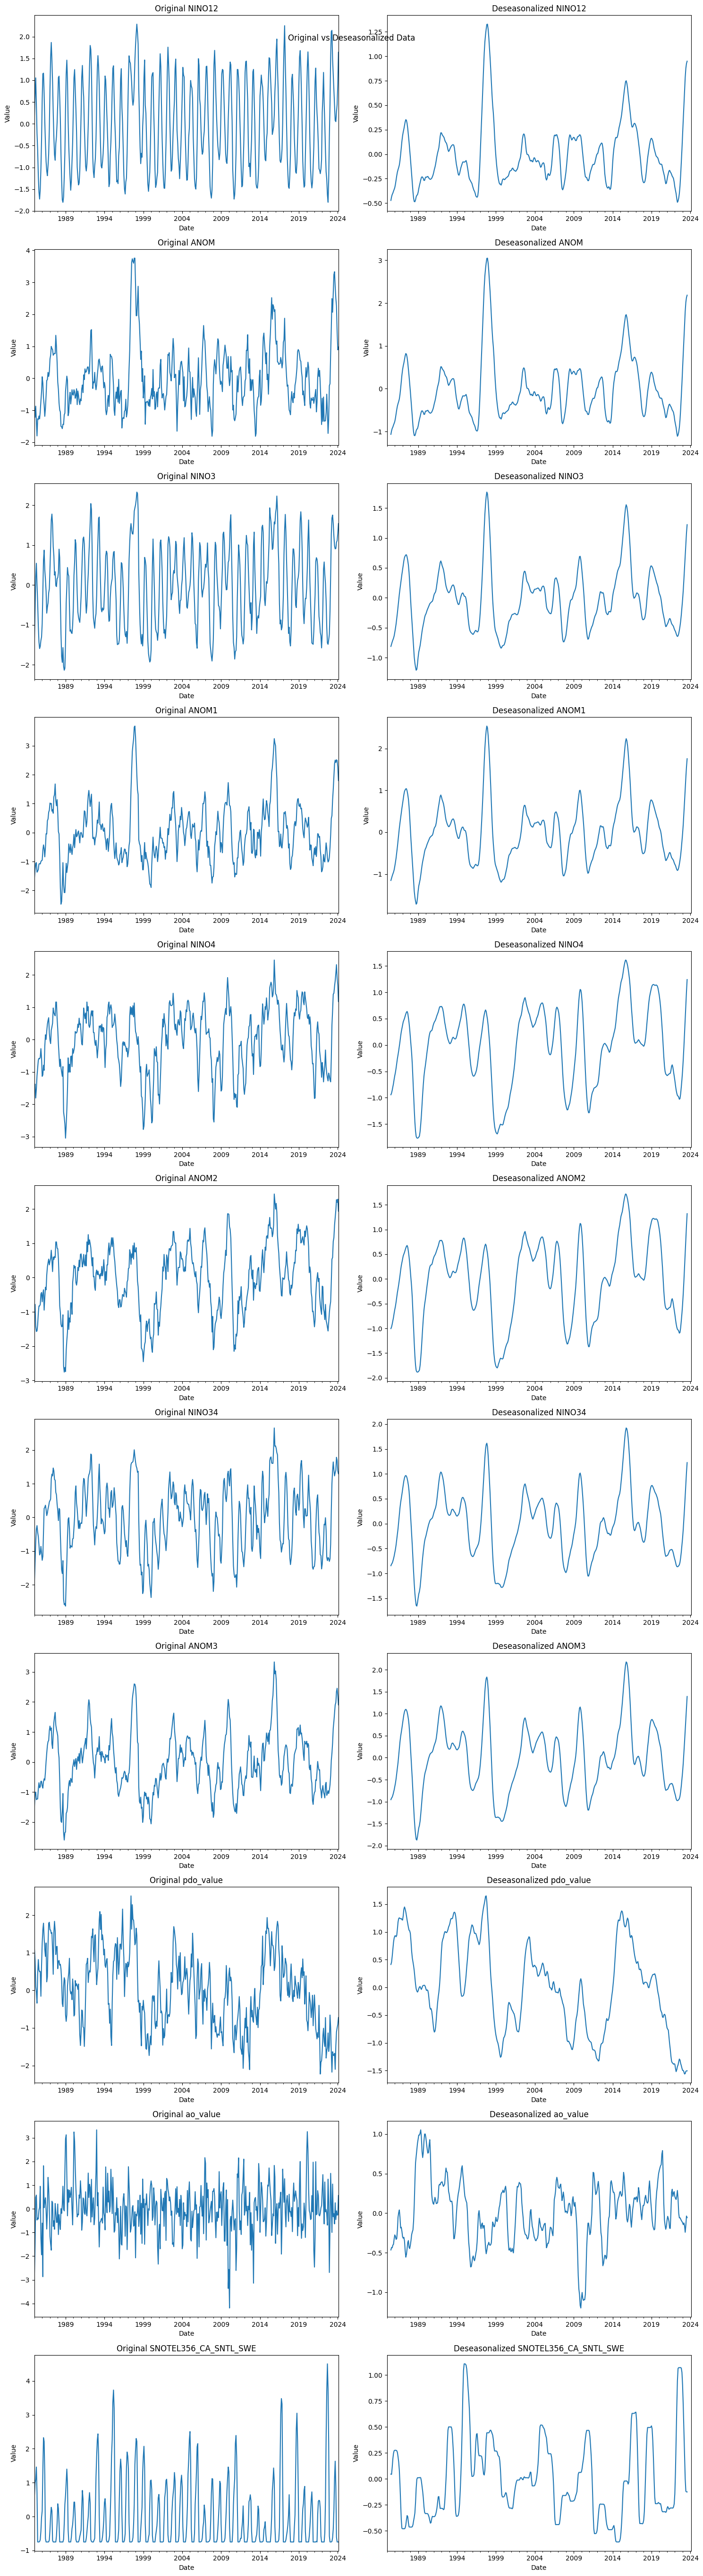

In [30]:
def remove_seasonality(df, column):
    decomposition = seasonal_decompose(df[column], period = 12)
    
    deseasonalized = decomposition.trend
    
    return deseasonalized

cols = df.columns
deseasonalized_df = pd.DataFrame(index=df.index)
for column in df.columns:
    deseasonalized_df[column] = remove_seasonality(df, column)

n_features = len(cols)
fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))
fig.suptitle('Original vs Deseasonalized Data')

for idx, cols in enumerate(cols):
    df[cols].plot(ax=axes[idx, 0], title=f'Original {cols}')
    axes[idx, 0].set_xlabel('Date')
    axes[idx, 0].set_ylabel('Value')
    
    deseasonalized_df[cols].plot(ax=axes[idx, 1], title=f'Deseasonalized {cols}')
    axes[idx, 1].set_xlabel('Date')
    axes[idx, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [35]:
df.loc[:, 'SNOTEL356_CA_SNTL_SWE'] = decomposed_snotel
df = df.dropna()

In [60]:
import pandas as pd
import numpy as np

def auto_corr(feat1, steps=36, df=df, feat2=last_column):
    corrs = []
    df = df[[feat1, feat2]].copy()
    
    for i in np.arange(-steps, 0):  # Include 0 shift
        shifted_df = df.copy()
        shifted_df[feat1] = shifted_df[feat1].shift(periods=i)
        correlation = shifted_df.dropna().corr().iloc[0, 1]
        corrs.append((i, correlation))
        
    return corrs

def find_max_correlation_shift(feature, df, target, steps=36):
    corrs = auto_corr(feature, steps=steps, df=df, feat2=target)
    shifts, correlations = zip(*corrs)
    max_corr_idx = np.argmax(np.abs(correlations))
    return shifts[max_corr_idx]

def shift_dataframe_for_max_correlation(df, target_column, steps=36):
    """
    Shifts each feature in the DataFrame to maximize its correlation with the target variable.
    
    Args:
    df (pd.DataFrame): The input DataFrame
    target_column (str): The name of the target column
    steps (int): The maximum number of steps to shift in either direction
    
    Returns:
    pd.DataFrame: A new DataFrame with shifted features
    dict: A dictionary of the shifts applied to each feature
    """
    feature_columns = [col for col in df.columns if col != target_column]
    shifted_df = pd.DataFrame()
    shift_dict = {}
    
    # Add the target column to the new DataFrame without shifting
    shifted_df[target_column] = df[target_column]
    
    for feature in feature_columns:
        max_shift = find_max_correlation_shift(feature, df, target_column, steps)
        shifted_df[f"{feature}_shifted"] = df[feature].shift(max_shift)
        shift_dict[feature] = max_shift
    
    # Remove rows with NaN values resulting from the shifts
    shifted_df = shifted_df.dropna()
    
    return shifted_df, shift_dict

# Usage example:
# Assuming 'df' is your original DataFrame and 'target_column' is the name of your target variable
shifted_df, shift_dict = shift_dataframe_for_max_correlation(df, target_column='SNOTEL356_CA_SNTL_SWE', steps=48)

# Print the shifts applied to each feature
for feature, shift in shift_dict.items():
    print(f"{feature} was shifted by {shift} periods")

# Now 'shifted_df' contains the shifted features and the target variable
# You can use this for further analysis or modeling

NINO12 was shifted by -8 periods
ANOM was shifted by -45 periods
NINO3 was shifted by -45 periods
ANOM1 was shifted by -45 periods
NINO4 was shifted by -45 periods
ANOM2 was shifted by -45 periods
NINO34 was shifted by -45 periods
ANOM3 was shifted by -45 periods
pdo_value was shifted by -42 periods
ao_value was shifted by -30 periods


In [61]:
shifted_df.corr()

,SNOTEL356_CA_SNTL_SWE,NINO12_shifted,ANOM_shifted,NINO3_shifted,ANOM1_shifted,NINO4_shifted,ANOM2_shifted,NINO34_shifted,ANOM3_shifted,pdo_value_shifted,ao_value_shifted
SNOTEL356_CA_SNTL_SWE,1.000000,-0.000742,-0.139900,-0.167896,-0.263000,-0.327627,-0.346876,-0.296364,-0.345166,-0.241454,-0.157537
NINO12_shifted,-0.000742,1.000000,-0.019860,0.676303,0.011635,-0.037823,0.048003,0.363457,0.023503,-0.026404,0.067001
ANOM_shifted,-0.139900,-0.019860,1.000000,0.553087,0.813099,0.398260,0.424074,0.551924,0.630042,0.245541,-0.034946
NINO3_shifted,-0.167896,0.676303,0.553087,1.000000,0.667502,0.412940,0.483835,0.841735,0.619003,0.233342,0.056075
ANOM1_shifted,-0.263000,0.011635,0.813099,0.667502,1.000000,0.678055,0.718393,0.809306,0.931339,0.361909,0.008836
NINO4_shifted,-0.327627,-0.037823,0.398260,0.412940,0.678055,1.000000,0.933151,0.797730,0.829547,0.407610,0.075916
ANOM2_shifted,-0.346876,0.048003,0.424074,0.483835,0.718393,0.933151,1.000000,0.764877,0.883866,0.401710,0.059903
NINO34_shifted,-0.296364,0.363457,0.551924,0.841735,0.809306,0.797730,0.764877,1.000000,0.864388,0.374131,0.083959
ANOM3_shifted,-0.345166,0.023503,0.630042,0.619003,0.931339,0.829547,0.883866,0.864388,1.000000,0.408302,0.041548
pdo_value_shifted,-0.241454,-0.026404,0.245541,0.233342,0.361909,0.407610,0.401710,0.374131,0.408302,1.000000,0.104938


In [62]:
shifted_df.shape

(413, 11)